## Perth Loop to Flopy

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape


%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

c:\users\00105295\projects\loopflopy\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel_routines
mesh
mesh_routines
modelling_routines_old
observations
project
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [2]:
# Project setup
name = 'perth'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)

### 2. Observation bores

In [14]:
# First sorting out observation bores
import process_observations
df_boreids = process_observations.prefilter_data()
df_boredetails = process_observations.assemble_clean_data(df_boreids)

from loopflopy.observations import Observations
observations = Observations(df_boredetails)
df_boredetails, df_obs = process_observations.add_WL_obs(df_boredetails)
#df_boredetails

In [15]:
#process_observations.plot_leederville_hydrographs(df_obs)
#process_observations.plot_yarragadee_hydrographs(df_obs)

### 3. Spatial

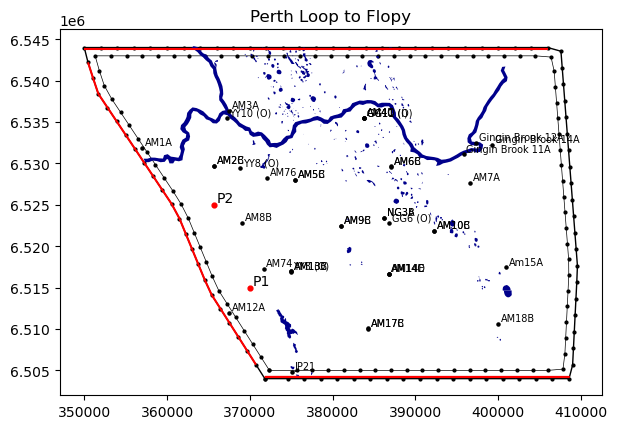

In [16]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial
process_spatial.make_bbox_shp(spatial, x0 = 348000, x1 = 415000, y0 = 6504000, y1 = 6544000)
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)

process_spatial.obs_bores(spatial, observations)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
#process_spatial.faults(spatial)
process_spatial.lakes(spatial)
process_spatial.river(spatial, node_spacing = 500, buffer_distance = 200, threshold = 100)
process_spatial.plot_spatial(spatial)

In [17]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')

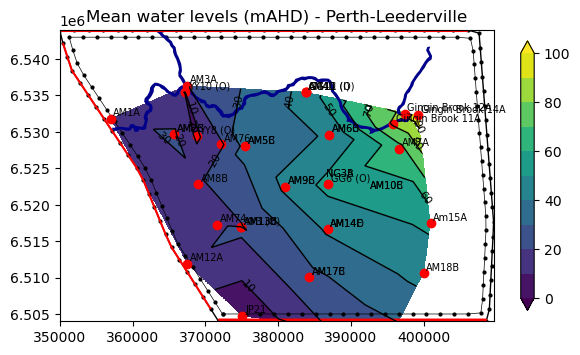

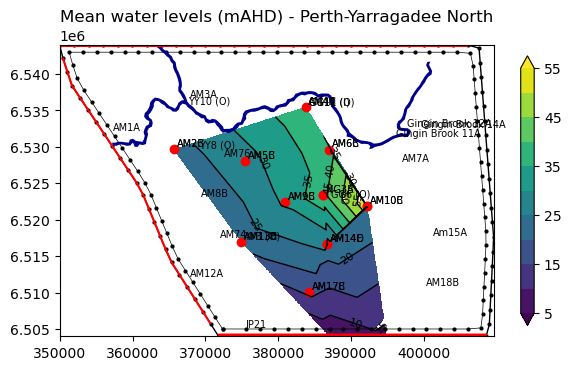

In [18]:
def plot_head_contours(spatial, df_boredetails, aquifername, contour_interval, extent = None):    # extent[[x0,x1], [y0,y1]]
    import math
    def rounded_down(number, contour_interval): # rounded_to is the nearest 1, 10, 100 etc
        return math.floor(number / contour_interval) * contour_interval
    def rounded_up(number, contour_interval): # rounded_to is the nearest 1, 10, 100 etc
        return math.ceil(number / contour_interval) * contour_interval

    # Create interpolation grid
    from scipy.interpolate import griddata
    x = np.linspace(spatial.x0-10000, spatial.x1+10000, 1000)
    y = np.linspace(spatial.y0-10000, spatial.y1+10000, 1000)
    X, Y = np.meshgrid(x, y)
    
    fig, ax = plt.subplots(figsize = (7,7))
    ax.set_title('Mean water levels (mAHD) - %s' %aquifername)
       
    x, y = spatial.model_boundary_poly.exterior.xy
    ax.plot(x, y, '-o', ms = 2, lw = 1, color='black')
    x, y = spatial.inner_boundary_poly.exterior.xy
    ax.plot(x, y, '-o', ms = 2, lw = 0.5, color='black')
    if extent: ax.set_xlim(extent[0][0], extent[0][1])
    if extent: ax.set_ylim(extent[1][0], extent[1][1])
        
    #spatial.faults_gdf.plot(ax=ax, markersize = 5, color = 'lightblue', zorder=2)
    spatial.river_gdf.plot(ax=ax, color = 'darkblue', lw = 0.5, zorder=2)
    spatial.chd_west_gdf.plot(ax=ax, markersize = 12, color = 'red', zorder=2)
    spatial.ghb_north_gdf.plot(ax=ax, markersize = 12, color = 'red', zorder=2)
    spatial.ghb_south_gdf.plot(ax=ax, markersize = 12, color = 'red', zorder=2)
    #spatial.obsbore_gdf.plot(ax=ax, markersize = 5, color = 'black', zorder=2)
    
    for x, y, label in zip(spatial.obsbore_gdf.geometry.x, spatial.obsbore_gdf.geometry.y, spatial.obsbore_gdf.ID):
        ax.annotate(label, xy=(x, y), xytext=(2, 2), size = 7, textcoords="offset points")

    # Plot contours
    df = df_boredetails[df_boredetails['Aquifer Name'] == aquifername]
    Z = griddata((df.Easting, df.Northing), df.mean_WL, (X, Y), method='linear')
    
    ax.plot(df.Easting, df.Northing, 'o', color = 'red')
    levels = np.arange(rounded_down(df.mean_WL.min(), contour_interval), 
                       rounded_up(df.mean_WL.max(),contour_interval)+contour_interval, 
                       contour_interval)
    
    ax.contour(X, Y, Z, levels = levels, extend = 'both', colors = 'Black', linewidths=1., linestyles = 'solid')
    c = ax.contourf(X, Y, Z, levels = levels, extend = 'both', cmap='viridis')
    ax.clabel(c, colors = 'black', inline=True, fontsize=8, fmt="%.0f")
    plt.colorbar(c, ax = ax, shrink = 0.5)

plot_head_contours(spatial, df_boredetails, 
                   aquifername = 'Perth-Leederville', 
                   contour_interval = 10,
                   extent = [[spatial.x0, spatial.x1], [spatial.y0,spatial.y1]])
plot_head_contours(spatial, df_boredetails, 
                   aquifername = 'Perth-Yarragadee North',
                   contour_interval = 5, 
                   extent = [[spatial.x0, spatial.x1], [spatial.y0,spatial.y1]])


### 3. Structural Model

In [19]:
# Create Structural Model
geodata_fname = '../data/data_dwer/geology.xls'
data_sheetname = 'bore_info'
strat_sheetname = 'strat_info'
bbox = [(343000, 6483000, -3000), (408000, 6564000, 500)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structuralmodel 
process_structuralmodel.prepare_strat_column(structuralmodel)
process_structuralmodel.prepare_geodata(structuralmodel, Lleyland = False, Brett = True, Fault_vert = True)
process_structuralmodel.create_structuralmodel(structuralmodel)

here NGG21A  13
here RG2 13
here KR5 13
here AM1 13
here GB5 13
here AM7 13
here AM15 13
here AM18A 13
here AM22 13
here AM26 13
here AM25 13
here AM29 13


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


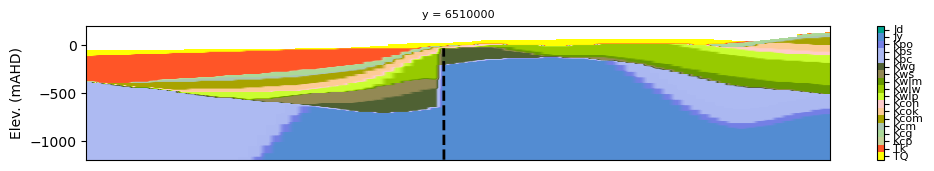

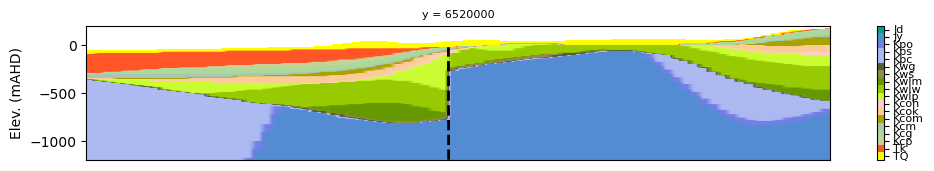

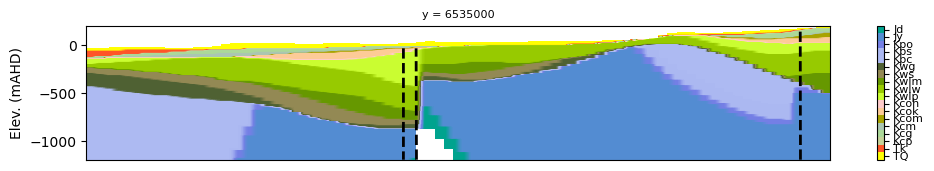

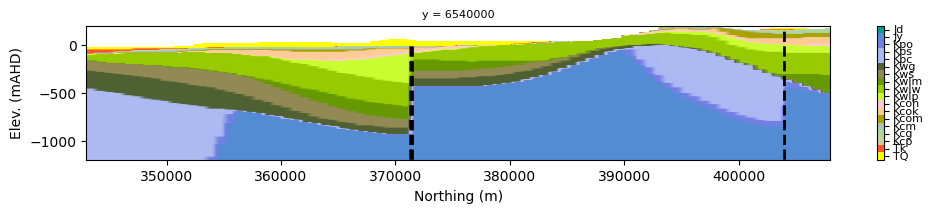

In [20]:
# Plot transects
structuralmodel.faults = ['Fault_1', 'Fault_2', 'Fault_3', 'Fault_4', 'Fault_5']
transect_x = [380000, 390000, 400000, 410000]
transect_y = [6510000, 6520000, 6535000, 6540000] 
#structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 120, x1 = 6520000, z0 = -2000) 
structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 120, z0 = -1200, z1 = 200) 

#structuralmodel.strat 
#structuralmodel.strat_col 
#structuralmodel.strat_names 
#structuralmodel.cmap
#structuralmodel.norm 
#structuralmodel.data

Removing faults nodes on  Fault_1  because too close to boundary:  [<POINT (374680.263 6504002.475)>, <POINT (374680.263 6504002.475)>, <POINT (374680.263 6504002.475)>, <POINT (374580.412 6505452.926)>, <POINT (374580.412 6505452.926)>, <POINT (370857.143 6542404.329)>, <POINT (370857.143 6542404.329)>, <POINT (370857.143 6542404.329)>, <POINT (370857.143 6542404.329)>, <POINT (370452.801 6543380.394)>, <POINT (370452.801 6543380.394)>, <POINT (370452.801 6543380.394)>, <POINT (370452.801 6543380.394)>]
Removing faults nodes on  Fault_2  because too close to boundary:  [<POINT (371719.742 6541829.731)>, <POINT (371719.742 6541829.731)>, <POINT (371941.539 6543312.74)>, <POINT (371941.539 6543312.74)>, <POINT (371941.539 6543312.74)>]
Removing faults nodes on  Fault_3  because too close to boundary:  [<POINT (375978.45 6542510.204)>, <POINT (375978.45 6542510.204)>, <POINT (375978.45 6542510.204)>, <POINT (375978.45 6542510.204)>, <POINT (375898.311 6543990.056)>, <POINT (375898.311 65

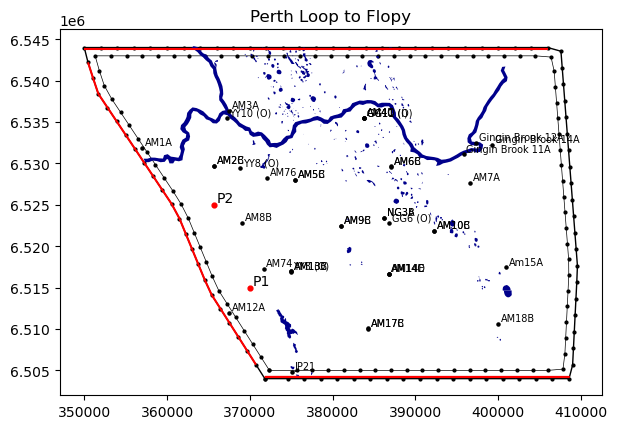

In [21]:
### Process fault

# Create empty gdf
df = pd.DataFrame(columns=['id', 'geometry'])
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs = spatial.epsg)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs = spatial.epsg)



for fault in structuralmodel.faults:
    #print("%s.pkl" %fault)
    with open("%s.pkl" %fault, 'rb') as picklefile:
        Fault = pickle.load(picklefile)
    x,y,z = list(zip(*Fault))
    fault_xy = list(zip(x, y))

    raw_line = LineString(fault_xy)
    points = list(raw_line.coords)
    sorted_points = sorted(points, key=lambda point: point[1]) # Sort the points by y-coordinate
    sorted_line = LineString(sorted_points)

    #from loopflopy.mesh_routines import resample_linestring
    #resampled_points = resample_linestring(raw_line, distance = 1000)
    #line = LineString(resampled_points)
    
    new_row = pd.DataFrame({'id': [fault], 'geometry': [sorted_line]})
    gdf = pd.concat([gdf, new_row], ignore_index=True)

gdf = gpd.clip(gdf, spatial.model_boundary_poly).reset_index(drop=True)

from loopflopy.mesh_routines import resample_linestring
import itertools

r = 1500 # distance between points
threshold_distance = 2000 # Don't want fault nodes too close to boundaries.
faults_ls, faults_coords = [], []

for i, ls in enumerate(gdf.geometry): # For each fault...    
    
    # STEP 1: Resample fault to have evenly spaced nodes at distance r
    ls_resample = resample_linestring(ls, r) # Resample linestring

    # STEP 2: Removing nodes too close to inner and outer boundary so mesh doesn't go crazy refined (threshold_distance)
    nodes_to_remove = []
    for p1 in ls_resample:
        for p2 in spatial.inner_boundary_poly.exterior.coords:
            p2 = Point(p2)
            if p1.distance(p2) <= threshold_distance:
                nodes_to_remove.append(p1)
        for p3 in spatial.model_boundary_poly.exterior.coords:
            p3 = Point(p3)
            if p1.distance(p3) <= threshold_distance:
                nodes_to_remove.append(p1)
    if nodes_to_remove:
        print('Removing faults nodes on ', gdf.loc[i, 'id'], ' because too close to boundary: ', nodes_to_remove)
    ls_new = [node for node in ls_resample if node not in nodes_to_remove]
    faults_ls.append(ls_new) # list of shapely points

    # STEP 3: Don't include short faults with only 1 node
    p = []
    for point in ls_new:
        x,y = point.x, point.y
        p.append((x,y))
    if len(p) > 1: # just making sure very short dykes with 1 point are not included
        faults_coords.append(p)

spatial.faults_nodes = list(itertools.chain.from_iterable(faults_coords))
spatial.faults_gdf = gdf

process_spatial.plot_spatial(spatial)#, extent = [[370000, 390000], [6520000, spatial.y1]])
#gdf.plot()

### 4. Refine around surface lithology

Max ground level =  359.8209533691406
Min ground level =  -53.94411789240989
No special cells
349987.28026856703 6504000.025298052
number of cells in plan =  2500
   Creating Geomodel (lithology and discretisation arrays) for  surf_lith  ...
Time taken =  456.199266


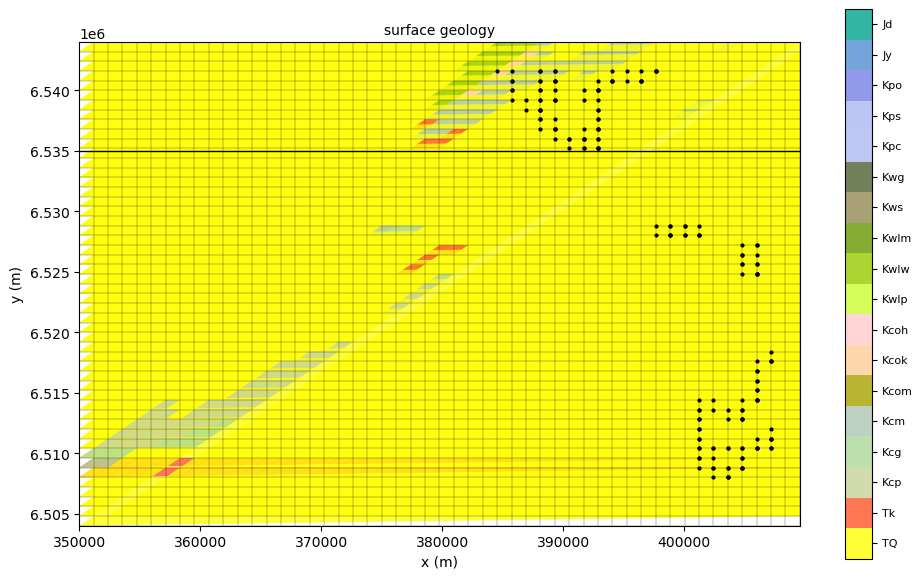

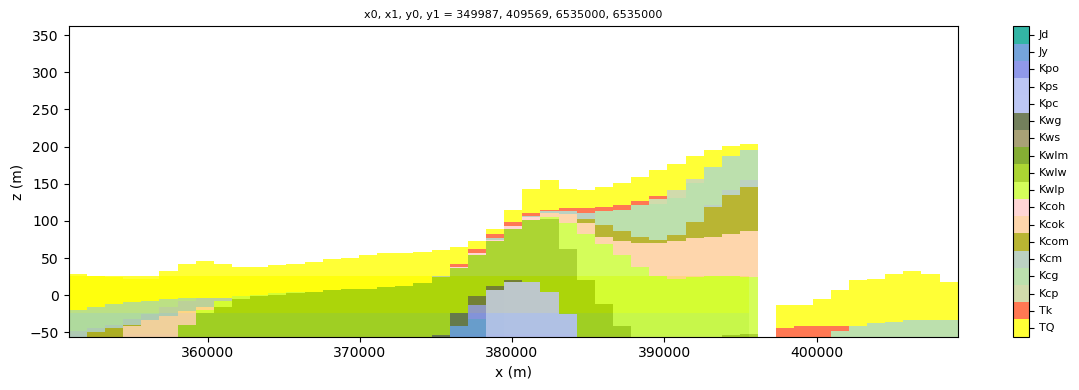

In [22]:
from loopflopy.surfacerefinement import SurfaceRefinement
surfacerefinement = SurfaceRefinement(structuralmodel, 70, 70)
surfacerefinement.create_surf_lith_raster(project, spatial, structuralmodel) 
surfacerefinement.generate_interface_nodes(spatial) # Generate nodes at the interfaces and saves as shp file
surfacerefinement.plot_surface_refinement(spatial, structuralmodel, y0 = 6535000, y1 = 6535000)


### 4. Meshing

In [23]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {'chd': ['west'], 
                 'ghb': ['north', 'south'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], 
                 #'poly': ['river']
                 }
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [61]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 1000000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 50 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 200 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['faults_nodes', 'bore_refinement_nodes', 'interface_nodes']#, 'river_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)


faults_nodes
bore_refinement_nodes
interface_nodes
number of cells in plan =  3397


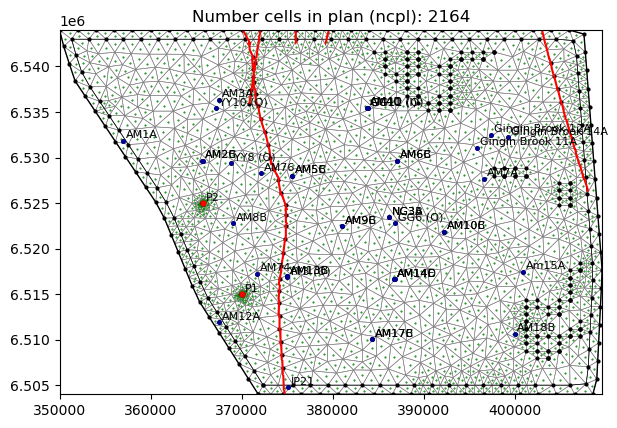

In [25]:

xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

xlim = [355000, 370000]
ylim = [6525000, 6535000]

features = ['wel', 'obs', 'fault']#,'river']
mesh.plot_cell2d(spatial, features)# xlim, ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['west']
Group =  ghb ['north', 'south']
Group =  wel ['pumpbores']
Group =  obs ['obsbores']


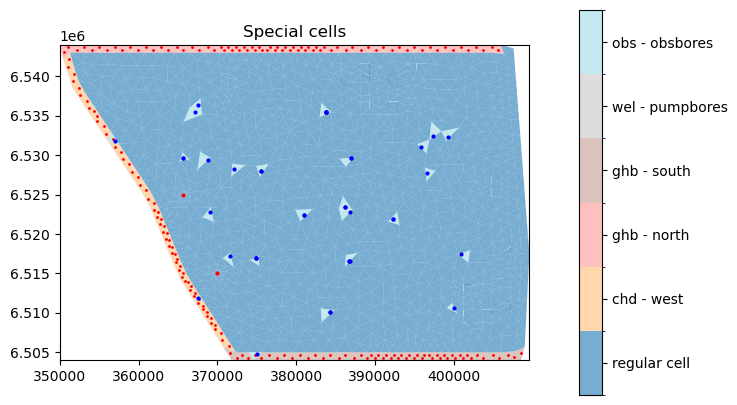

In [26]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### DEM

In [27]:
from process_dem import DEM

geotiff_fname = "../data/data_dem/Hydro_Enforced_1_Second_DEM.tif"
uncropped_dem = DEM(geotiff_fname = geotiff_fname)
bbox_path = "../data/data_shp/bbox/bbox.shp"
uncropped_dem.crop_raster(bbox_path)

geotiff_fname = '../data/data_dem/cropped_raster.tif'
cropped_dem = DEM(geotiff_fname = geotiff_fname)
#cropped_dem.plot_geotiff()

EPSG:28350
EPSG:28350


In [28]:
# Resample DEM onto a coarse grid and save as xyz list to be used in structural model
fname = project.workspace + 'topo_xyz.pkl'
cropped_dem.topo = cropped_dem.resample_topo(project, structuralmodel, nrow = 20, ncol = 20, fname = fname)   # This creates a pickle file of resampled x,y,z to use in structural model
#plt.imshow(cropped_dem.topo)
levels = np.arange(-50, 300, 50)
#cropped_dem.plot_topo(levels=levels)

fname = project.workspace + 'topo_xyz.pkl'
pickleoff = open(fname,'rb')
topo_xyz = pickle.load(pickleoff)
pickleoff.close()

#topo_xyz

### 5. Geomodel

In [29]:
# Set up Geomodel (lithological block model of cells)
scenario = 's1'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -500, 400 #structuralmodel.max_RL + 10    #-1500, 400

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 4)

geomodel.create_lith_dis_arrays(mesh, structuralmodel)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)
geomodel.get_surface_lith()


   Creating Geomodel (lithology and discretisation arrays) for  s1  ...
Time taken =  1176.636532


In [30]:
#print('idomain_geo', geomodel.idomain_geo[:,2635])
#print('top_geo', geomodel.top_geo[2635])
#print('botm_geo', geomodel.botm_geo[:,2635])
#print(geomodel.botm[:,2635])
#print(geomodel.lith.shape)
#print(np.unique(geomodel.idomain_geo, return_counts = True))
#print(np.unique(geomodel.idomain, return_counts = True))

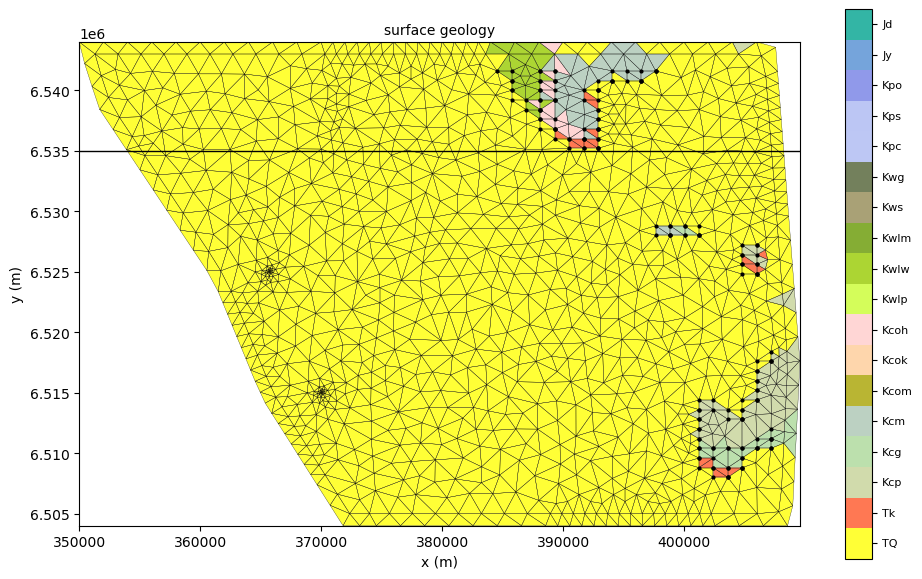

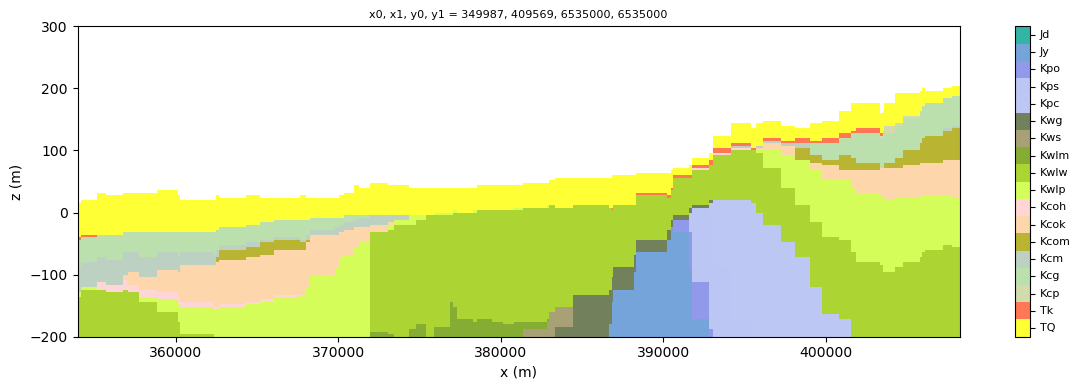

In [31]:
y0, y1 = 6535000, 6535000
geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel, y0=y0, y1=y1)
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1, z0 = -200, z1 = 300)#, z0 = -900, z1 = -2000) 

In [32]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = structuralmodel.strat_sheetname)
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.fill_cell_properties(mesh)
props

   Filling cell properties for  s1  ...
357 (36, 2164)
357 (36, 2164)
Time taken =  0.031082


,index,sequence,unit,R,G,B,val,lithid,Thickness,hk,vk,ss,sy,ch_west
0,1,Quaternary,TQ,255,255,0,-44,0,44,20.0,2.00,0.00001,0.1,10.0
1,2,Tertiary,Tk,255,81,42,-161,1,117,5.0,0.50,0.00001,0.1,NaN
2,3,Lancelin,Kcp,196,214,155,-186,2,25,1.0,0.10,0.00001,0.1,NaN
3,4,Lancelin,Kcg,170,217,153,-230,3,44,1.0,0.10,0.00001,0.1,NaN
4,5,Lancelin,Kcm,171,199,182,-253,4,23,1.0,0.10,0.00001,0.1,NaN
5,6,Osbourne,Kcom,168,164,0,-313,5,60,1.0,0.10,0.00001,0.1,NaN
6,7,Osbourne,Kcok,255,204,153,-364,6,51,0.1,0.01,0.00001,0.1,NaN
7,8,Osbourne,Kcoh,255,204,204,-386,7,22,1.0,0.10,0.00001,0.1,NaN
8,9,Leederville,Kwlp,204,255,51,-440,8,54,1.0,0.10,0.00001,0.1,15.0
9,10,Leederville,Kwlw,153,204,0,-607,9,167,10.0,1.00,0.00001,0.1,15.0


In [33]:
#geomodel.model_layers
#geomodel.hk_perlay

### 6. Prepare Data for Flowmodel

In [34]:
from process_data import Data
data = Data()

data.process_ic(geomodel, mesh)
data.process_rch(mesh)
data.process_chd(geomodel, mesh, props)


[[np.int64(87), np.float64(10.0)],
 [np.int64(2048), np.float64(10.0)],
 [np.int64(17587), np.float64(15.0)],
 [np.int64(18926), np.float64(15.0)],
 [np.int64(20268), np.float64(15.0)],
 [np.int64(22369), np.float64(15.0)],
 [np.int64(155), np.float64(10.0)],
 [np.int64(2116), np.float64(10.0)],
 [np.int64(17615), np.float64(15.0)],
 [np.int64(18954), np.float64(15.0)],
 [np.int64(20330), np.float64(15.0)],
 [np.int64(22431), np.float64(15.0)],
 [np.int64(86), np.float64(10.0)],
 [np.int64(2047), np.float64(10.0)],
 [np.int64(17586), np.float64(15.0)],
 [np.int64(18925), np.float64(15.0)],
 [np.int64(20267), np.float64(15.0)],
 [np.int64(22368), np.float64(15.0)],
 [np.int64(903), np.float64(10.0)],
 [np.int64(2864), np.float64(10.0)],
 [np.int64(18284), np.float64(15.0)],
 [np.int64(19623), np.float64(15.0)],
 [np.int64(21269), np.float64(15.0)],
 [np.int64(23370), np.float64(15.0)],
 [np.int64(34), np.float64(10.0)],
 [np.int64(1995), np.float64(10.0)],
 [np.int64(17541), np.float64(

In [35]:
wel_q = [-0, -0]
wel_qlay= [5, 2]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)

# Connect observation points to unstrctured grid
observations.process_obs(spatial, geomodel, mesh)
observations.obs_rec

29
67
[(np.float64(-192.0), np.float64(-220.0)), (np.float64(-92.0), np.float64(-116.0))]
No obs at (386759.450000, 6516637.450000, -652.058000)
No obs at (367534.260000, 6511903.420000, -535.207000)
No obs at (369013.010000, 6522807.500000, -589.148000)
No obs at (365662.080000, 6529654.320000, -830.893000)


[['AM18B', 'head', np.int64(21000)],
 ['Am15A', 'head', np.int64(23594)],
 ['AM10B', 'head', np.int64(31982)],
 ['AM10C', 'head', np.int64(24181)],
 ['AM7A', 'head', np.int64(23433)],
 ['AM6B', 'head', np.int64(32038)],
 ['AM17B', 'head', np.int64(31912)],
 ['AM17C', 'head', np.int64(24036)],
 ['AM14E', 'head', np.int64(23827)],
 ['AM14D', 'head', np.int64(31818)],
 ['AM9B', 'head', np.int64(32155)],
 ['AM9C', 'head', np.int64(20186)],
 ['GG6 (O)', 'head', np.int64(3627)],
 ['NG3B', 'head', np.int64(31953)],
 ['NG3A', 'head', np.int64(31953)],
 ['JP21', 'head', np.int64(13964)],
 ['YY3 (O)', 'head', np.int64(10658)],
 ['AM13B', 'head', np.int64(32474)],
 ['AM13C', 'head', np.int64(23398)],
 ['AM74', 'head', np.int64(19285)],
 ['AM5C', 'head', np.int64(23668)],
 ['AM76', 'head', np.int64(19206)],
 ['YY8 (O)', 'head', np.int64(3253)],
 ['AM6C', 'head', np.int64(3761)],
 ['Gingin Brook 11A', 'head', np.int64(21642)],
 ['Gingin Brook 14A', 'head', np.int64(18408)],
 ['Gingin Brook 12A', 'h

### 8. Create and run steady-state flow model

In [36]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
fm.lith = geomodel.lith
fm.logk11 = geomodel.logk11
fm.logk33 = geomodel.logk33
len(fm.logk33.flatten())


33032

In [37]:
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
data
geomodel
lith
logk11
logk33
mesh
newtonoptions
observations
project
scenario
staggered
xt3d


In [45]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
   Time taken to write flow model =  12.135743
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  9.939626
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 33032)


Node one based =  13419 Node zero based =  13418
XYZ problem =  403376.33535161417 6538695.12613502 61.0
cell width approx  1460.1345615147147
cell length approx  1499.4437257284299
cell thickness 22.0
lay, icpl (12, 1085)


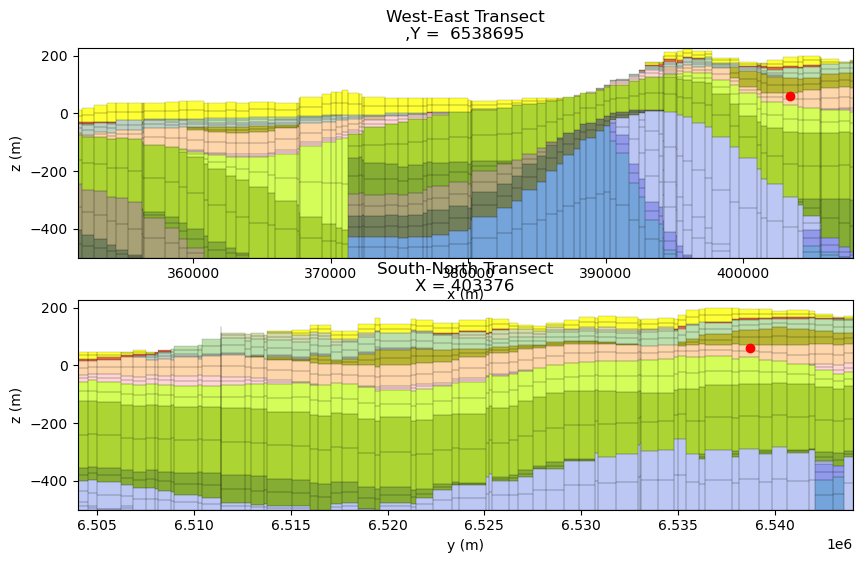

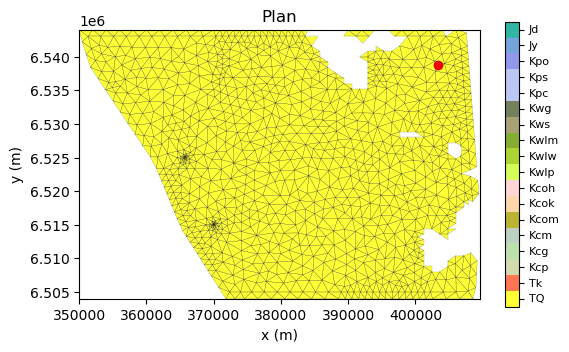

In [56]:
utils.plot_node(13418, geomodel, structuralmodel, spatial, sim, scenario)

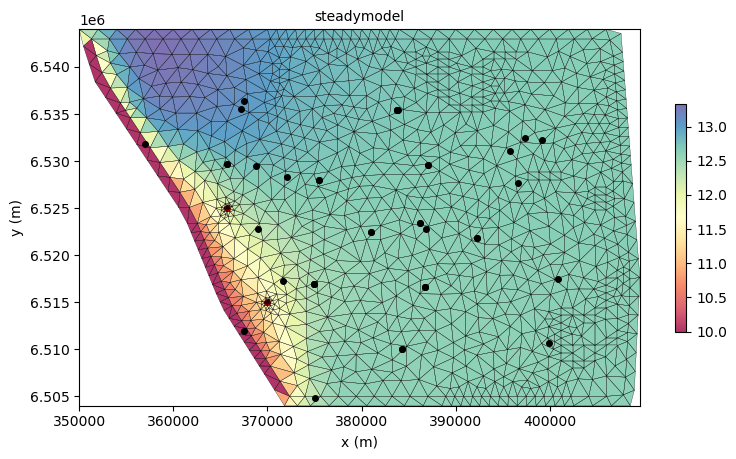

In [ ]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable,)#, extent, vmin, vmax

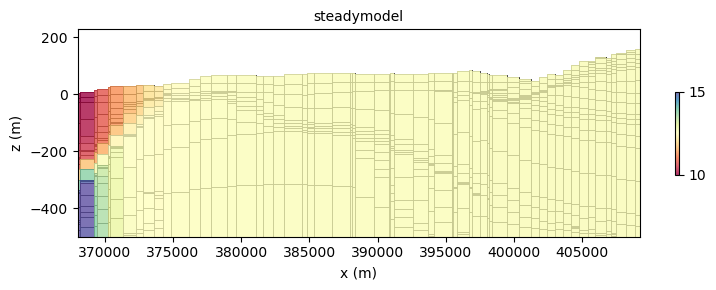

In [58]:
fm.plot_transect(spatial, 'head',  y0 = 6510000, y1 = 6510000)#, X0, X1, Y0, Y1)

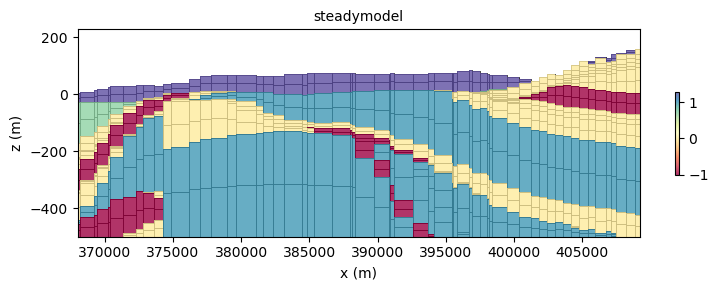

In [59]:
fm.plot_transect(spatial, 'logk11', y0 = 6510000, y1 = 6510000)

In [ ]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

### 9. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 10. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 11. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  

In [ ]:
def print_object_details(obj):
    all_attributes_methods = dir(obj)
    methods = [attr for attr in all_attributes_methods if callable(getattr(obj, attr)) and not attr.startswith("__")]
    variables = [attr for attr in all_attributes_methods if not callable(getattr(obj, attr)) and not attr.startswith("__")]

    print('Methods:')
    for method in methods: print(method)
    print("\nVariables")
    for variable in variables: print(variable)

In [ ]:
from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.3, allow_holes = True)#False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

unique_surf_liths = np.unique(geomodel.surf_lith)

def smooth_polygons(polygon, buffer_distance=0.001):
    return polygon.buffer(buffer_distance).buffer(-buffer_distance)
def is_even(number):
    return number % 2 == 0

polygons = []
for i, lith in enumerate(unique_surf_liths):
    if not is_even(i): # only create polygons for even lithologies so boundaries dont overlap
        gdf, hull_gdf = create_surfacegeo_polys(geomodel, lith)
        gs = hull_gdf.geometry.apply(lambda geom: shape(geom))
        print(type(gs))
        print(gs)
        smoothed_gs = gs.apply(smooth_polygons)
        for smoothed_poly in smoothed_gs:
            polygons.append(smoothed_poly)
    

    fig, ax = plt.subplots()
    ax.set_title('Lithology' + str(lith))
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.show()

lith_boundaries_gdf = gpd.GeoDataFrame(geometry=polygons)
fig, ax = plt.subplots()
ax.set_title('Lithology boundaries')
lith_boundaries_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
plt.show()
    


In [ ]:
#def create_fine_grid(X, Y, num_points=500):
#    x_fine = np.linspace(X.min(), X.max(), num_points)
#    y_fine = np.linspace(Y.min(), Y.max(), num_points)
#    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
#    return X_fine, Y_fine
#
#def interpolate_data(X, Y, Z, X_fine, Y_fine):
#    from scipy.interpolate import griddata
#    Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')
#    return Z_fine

#def plot_smooth_contours(X_fine, Y_fine, Z_fine, levels=10):
#    plt.figure(figsize=(8, 6))
#    contour = plt.contour(X_fine, Y_fine, Z_fine, levels=levels, cmap='viridis')
#    plt.colorbar(contour)
#    plt.title('Smooth Contour Lines')
#    plt.xlabel('X')
#    plt.ylabel('Y')
#    plt.show()
#    return contour

def plot_contours(X, Y, Z, levels=10):
    plt.figure(figsize=(8, 6))
    contour = plt.contour(X, Y, Z, levels=levels, cmap='viridis')
    plt.colorbar(contour)
    plt.title('Contour Lines')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return contour

def extract_contour_lines(contour):
    contour_lines = []
    for collection in contour.collections:
        for path in collection.get_paths():
            v = path.vertices
            contour_lines.append(LineString(v))
    return contour_lines

def save_contour_lines_to_shapefile(contour_lines, filename):
    gdf = gpd.GeoDataFrame(geometry=contour_lines)
    gdf.to_file(filename)


#X_fine, Y_fine = create_fine_grid(X, Y)
#Z_fine = interpolate_data(X, Y, Z, X_fine, Y_fine)
#plt.imshow(Z_fine)
#levels =[-0.09, 0.01, 1.01, 2.01, 3.01, 4.01,]
X, Y = mesh.xcenters, mesh.ycenters
Z = geomodel.surf_lith.reshape(mesh.nrow, mesh.ncol)
contour = plot_contours(X, Y, Z, levels =levels)
contour_lines = extract_contour_lines(contour)
save_contour_lines_to_shapefile(contour_lines, "contour_lines.shp")